# Proyecto Aurelion - IA Fundamentals
## IBM - Guayerd 2025

## Spring 3 - Implementación de Modelos de Machine Learning para análisis predictivo de ventas

**Autor:** Grupo 6

**Fecha:** 17 de noviembre de 2025  

**Dataset:** df_master.xlsx 

## Objetivo del Proyecto

Desarrollar modelos de machine learning para predecir:
1. **Monto final de ventas** (regresión)
2. **Rango de edad de clientes** (clasificación)
3. **Categoría de producto más probable** (clasificación)
4. **Es venta premium** (clasificación)
5. **Segmento de clientes por género** (clasificación)

Utilizaremos el dataset `df_master.xlsx` trabajado en Spring 2, contiene información completa de transacciones de ventas retail.

### Importación de Librerías

Importamos todas las librerías necesarias para el análisis y modelado:

In [129]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualización
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

### Carga y Exploración del Dataset

Cargamos el dataset y realizamos una exploración inicial de los datos:

In [130]:
# Cargar el dataset
ruta_spring_2 = 'C:\\Users\\KEILY\\Downloads\\Music\\IBM-GUAYERD\\Proyecto-Aurelion-IBM-Guayerd-edit-clone\\Proyecto-Aurelion-IBM-Guayerd\\SPRING_2'
ruta_spring_3 = 'C:\\Users\\KEILY\\Downloads\\Music\\IBM-GUAYERD\\Proyecto-Aurelion-IBM-Guayerd-edit-clone\\Proyecto-Aurelion-IBM-Guayerd\\SPRING_3'

df_master = pd.read_excel(ruta_spring_2 + '/df_master.xlsx')

# Información básica del dataset
print("=== INFORMACIÓN DEL DATASET ===")
print(f"Dimensiones: {df_master.shape}")
print(f"Columnas: {df_master.columns.tolist()}")
print(f"\nPrimeras 5 filas:")
print(df_master.head())

# Verificar valores faltantes
print(f"\nValores faltantes por columna:")
print(df_master.isnull().sum().sum(), "valores faltantes en total")

=== INFORMACIÓN DEL DATASET ===
Dimensiones: (2016, 38)
Columnas: ['id_venta', 'id_producto', 'nombre_producto_x', 'cantidad', 'precio_unitario_x', 'importe', 'descuento_aplicado_pct', 'subtotal', 'nombre_producto_y', 'categoria', 'precio_unitario_y', 'subcategoria', 'fecha', 'id_cliente', 'id_sucursal_x', 'id_vendedor', 'id_medio_pago', 'nombre_cliente_x', 'email_x', 'medio_pago_original', 'estado_venta', 'monto_bruto', 'monto_neto', 'nombre_cliente_y', 'email_y', 'ciudad_x', 'fecha_alta', 'genero', 'edad_rango', 'activo_como_cliente', 'nombre_sucursal', 'ciudad_y', 'provincia', 'nombre_vendedor', 'id_sucursal_y', 'fecha_ingreso', 'activo', 'nombre_medio_pago']

Primeras 5 filas:
   id_venta  id_producto      nombre_producto_x  cantidad  precio_unitario_x  \
0         1           90    Toallas Húmedas x50         1              29.02   
1         2           82  Aceitunas Negras 200g         5              23.94   
2         2           39     Helado Vainilla 1L         5             

### Resumen general del dataset

| Categoría                       | Información                                                                                                  |
| ------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Filas totales**               | 2,016                                                                                                        |
| **Columnas totales**            | 38                                                                                                           |
| **Valores faltantes**           | 0 (dataset completo)                                                                                         |
| **Variables numéricas clave**   | cantidad, precio_unitario_x, importe, subtotal, monto_bruto, monto_neto, descuento_aplicado_pct              |
| **Variables categóricas clave** | categoria, genero, medio_pago_original, nombre_sucursal, ciudad_x, provincia                                 |
| **Estado del dataset**          |  Limpio y listo para modelado                                                                                |
| **Balance de clases**           | Desbalanceado → para clasificación usar  SMOTE                                                               |
| **Calidad general**             | Alta (sin nulos, sin problemas de formato)                                                                   |
| **Origen**                      | Ventas + Clientes + Productos + Sucursales + Medios de pago  + Vendedores                                    |


## Limpieza y Optimización del DataFrame Master
- Limpieza de datos faltantes y duplicados
- Validación de la integridad del DataFrame
- Transformación de variables categóricas y numéricas
- Marcado de outliers
- Optimización mediante normalización y escalado de datos
- Verficación final del DataFrame limpio y optimizado
- Carga del DataFrame limpio para modelado



In [131]:
#Limpieza y optimización df_master
print("LIMPIEZA Y OPTIMIZACIÓN DEL DF_MASTER")
print("="*60)



# 1. Crear copia de trabajo
df_to_refined = df_master.copy()
print(f" Dataset original (df_master) cargado desde memoria: {df_to_refined.shape}")

# === FASE 1: LIMPIEZA BÁSICA ===
print(f"\n FASE 1: LIMPIEZA BÁSICA")
print("-" * 40)

# 2. Eliminar duplicados
print(f"Antes de limpieza: {len(df_to_refined)} registros")
duplicados_antes = df_to_refined.duplicated().sum()
print(f"Duplicados encontrados: {duplicados_antes}")

# Mostrar duplicados antes de eliminar
if duplicados_antes > 0:
    print("\nDuplicados identificados:")
    duplicados_idx = df_to_refined[df_to_refined.duplicated(keep=False)].index
    for idx in duplicados_idx[:6]:  # Mostrar primeros 6
        row = df_to_refined.loc[idx]
        # Intentar acceder a columnas que esperamos estén en df_refined
        nombre_cliente_display = row['nombre_cliente_x'] if 'nombre_cliente_x' in row else 'N/A'
        id_venta_display = row['id_venta'] if 'id_venta' in row else 'N/A'
        print(f"  Fila {idx}: Venta {id_venta_display}, Cliente {str(nombre_cliente_display)[:15]}...")

df_refined = df_to_refined.drop_duplicates(keep='first')
print(f"Después de limpieza: {len(df_refined)} registros")
print(f"✅ Duplicados eliminados: {duplicados_antes}")

# 3. Validar reglas de negocio
print(f"\nValidando reglas de negocio...")
errores = []

# Asegurarse de que las columnas existen antes de la validación
if 'monto_bruto' in df_refined.columns and 'monto_neto' in df_refined.columns:
    if not (df_refined['monto_bruto'] >= df_refined['monto_neto']).all():
        errores.append("monto_bruto < monto_neto")
    if not (df_refined['monto_neto'] >= 0).all():
        errores.append("monto_neto negativo")
else:
    if 'monto_bruto' not in df_refined.columns: errores.append("Columna 'monto_bruto' no encontrada")
    if 'monto_neto' not in df_refined.columns: errores.append("Columna 'monto_neto' no encontrada")

if 'cantidad' in df_refined.columns:
    if not (df_refined['cantidad'] >= 1).all():
        errores.append("cantidad inválida")
else:
    errores.append("Columna 'cantidad' no encontrada")

if len(errores) == 0:
    print("✅ Todas las reglas de negocio están correctas")
else:
    print(f"Errores encontrados: {errores}")

# === FASE 2: TRANSFORMACIÓN DE VARIABLES ===
print(f"\nFASE 2: TRANSFORMACIÓN DE VARIABLES")
print("-" * 40)

# 4. Crear nuevas características transformadas
print("Creando variables transformadas...")

# 4.1. `tipo_descuento`
if 'descuento_aplicado_pct' in df_refined.columns:
    df_refined['tipo_descuento'] = df_refined['descuento_aplicado_pct'].apply(
        lambda x: 'sin_descuento' if x == 0 else f'descuento_{int(x)}'
    )
    print("Distribución de tipos de descuento:")
    print(df_refined['tipo_descuento'].value_counts())
else:
    print("Columna 'descuento_aplicado_pct' no encontrada para crear 'tipo_descuento'.")

# 4.2. `ticket_promedio`
if 'importe' in df_refined.columns and 'cantidad' in df_refined.columns:
    df_refined['ticket_promedio'] = df_refined['importe'] / df_refined['cantidad']
    print(f"  - ticket_promedio: rango ${df_refined['ticket_promedio'].min():.2f} - ${df_refined['ticket_promedio'].max():.2f}")
else:
    print("Columnas 'importe' o 'cantidad' no encontradas para crear 'ticket_promedio'.")

# 4.3. `es_venta_premium`
if 'monto_neto' in df_refined.columns:
    df_refined['es_venta_premium'] = df_refined['monto_neto'] > df_refined['monto_neto'].quantile(0.95)
    print(f"  - ventas premium: {df_refined['es_venta_premium'].sum()} registros ({df_refined['es_venta_premium'].mean()*100:.1f}%) ")
else:
    print("Columna 'monto_neto' no encontrada para crear 'es_venta_premium'.")

# 4.4. `ratio_precio_cantidad`
if 'precio_unitario_x' in df_refined.columns and 'cantidad' in df_refined.columns:
    df_refined['ratio_precio_cantidad'] = df_refined['precio_unitario_x'] / df_refined['cantidad']
    print(f"  - ratio_precio_cantidad: rango {df_refined['ratio_precio_cantidad'].min():.2f} - {df_refined['ratio_precio_cantidad'].max():.2f}")
else:
    print("Columnas 'precio_unitario_x' o 'cantidad' no encontradas para crear 'ratio_precio_cantidad'.")

# 4.5. `tiene_descuento`
if 'descuento_aplicado_pct' in df_refined.columns:
    df_refined['tiene_descuento'] = df_refined['descuento_aplicado_pct'] > 0
    print(f"  - ventas con descuento: {df_refined['tiene_descuento'].sum()} registros ({df_refined['tiene_descuento'].mean()*100:.1f}%) ")
else:
    print("Columna 'descuento_aplicado_pct' no encontrada para crear 'tiene_descuento'.")
    
# 4.6. Otras características temporales y monetarias
print("\nVerificando y generando características temporales...")

# Generar columna de monto_final si no existe
if 'monto_final' not in df_refined.columns:
    df_refined['monto_final'] = df_refined['subtotal'] - (
        df_refined['subtotal'] * df_refined['descuento_aplicado_pct'] / 100 
    )
    print("   ✓ Columna 'monto_final' generada")

# Generar columna de trimestre
if 'trimestre' not in df_refined.columns:
    df_refined['trimestre'] = df_refined['fecha'].dt.quarter
    print("   ✓ Columna 'trimestre' generada")

# === FASE 3: MARCADO DE OUTLIERS ===
print(f"\n FASE 3: MARCADO DE OUTLIERS")
print("-" * 40)

# 5. Marcar outliers para `monto_neto` usando IQR
if 'monto_neto' in df_refined.columns:
    Q1 = df_refined['monto_neto'].quantile(0.25)
    Q3 = df_refined['monto_neto'].quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR
    df_refined['es_outlier_monto'] = df_refined['monto_neto'] > limite_superior

    print(f"Outliers marcados (método IQR) para monto_neto:")
    print(f"  - Límite superior: ${limite_superior:.2f}")
    print(f"  - Outliers detectados: {df_refined['es_outlier_monto'].sum()} ({df_refined['es_outlier_monto'].mean()*100:.1f}%) ")

    if df_refined['es_outlier_monto'].sum() > 0 and 'nombre_cliente_x' in df_refined.columns:
        outliers_info = df_refined[df_refined['es_outlier_monto']]
        print(f"\nClientes en outliers:")
        print(outliers_info['nombre_cliente_x'].value_counts())
else:
    print("Columna 'monto_neto' no encontrada para la detección de outliers.")

# === FASE 4: OPTIMIZACIÓN PARA ML ===
print(f"\n FASE 4: OPTIMIZACIÓN PARA MACHINE LEARNING")
print("-" * 40)

# 6. Generar variables de tiempo
if 'fecha' in df_refined.columns:
    df_refined['año'] = df_refined['fecha'].dt.year
    df_refined['mes'] = df_refined['fecha'].dt.month
    df_refined['dia_semana'] = df_refined['fecha'].dt.dayofweek
    df_refined['es_finde_semana'] = df_refined['dia_semana'].isin([5, 6]).astype(int)
    print(f"✅ Variables de tiempo creadas: año, mes, dia_semana, es_finde_semana")
else:
    print("Columna 'fecha' no encontrada para crear variables de tiempo.")

# 7. Calcular `dias_desde_alta`
if 'fecha' in df_refined.columns and 'fecha_alta' in df_refined.columns:
    df_refined['dias_desde_alta'] = (df_refined['fecha'] - df_refined['fecha_alta']).dt.days
    print(f"✅ Variable 'dias_desde_alta' creada")
else:
    print("Columnas 'fecha' o 'fecha_alta' no encontradas para crear 'dias_desde_alta'.")

# 8. Codificar variables categóricas importantes
categorias_importantes = ['genero', 'edad_rango', 'categoria', 'tipo_descuento', 'medio_pago_original']
for cat_col in categorias_importantes:
    if cat_col in df_refined.columns:
        le = LabelEncoder()
        df_refined[f'{cat_col}_encoded'] = le.fit_transform(df_refined[cat_col])
        print(f"✅ '{cat_col}' codificada: {len(le.classes_)} categorías")
    else:
        print(f"Columna '{cat_col}' no encontrada para codificar.")

# === FASE 5: ESTADÍSTICAS FINALES ===
print(f"\n FASE 5: ESTADÍSTICAS FINALES")
print("-" * 40)

# 9. Imprimir resumen del df_refined final
print(f"Dataset final:")
print(f"  - Registros: {len(df_refined)} (original: {len(df_to_refined)})")
print(f"  - Variables: {len(df_refined.columns)} (original: {len(df_to_refined.columns)})")
print(f"  - Variables numéricas: {len(df_refined.select_dtypes(include=[np.number]).columns)}")
print(f"  - Variables categóricas: {len(df_refined.select_dtypes(include=['object']).columns)}")
print(f"  - Variables de fecha: {len(df_refined.select_dtypes(include=['datetime64[ns]']).columns)}")

print(f"\nVariables objetivo listas para ML:")
variables_objetivo_ml = ['monto_final', 'edad_rango', 'categoria', 'es_venta_premium']
for var_ml in variables_objetivo_ml:
    if var_ml in df_refined.columns:
        if df_refined[var_ml].dtype in ['float64', 'int64'] and df_refined[var_ml].nunique() > 2:
            print(f"  - '{var_ml}': REGRESIÓN (continua, rango ${df_refined[var_ml].min():.2f} - ${df_refined[var_ml].max():.2f})")
        elif df_refined[var_ml].dtype == 'bool' or (df_refined[var_ml].dtype == 'int64' and df_refined[var_ml].nunique() == 2):
            print(f"  - '{var_ml}': CLASIFICACIÓN BINARIA ({df_refined[var_ml].sum()} casos positivos)")
        elif df_refined[var_ml].dtype == 'object' or df_refined[var_ml].nunique() > 2:
            print(f"  - '{var_ml}': CLASIFICACIÓN ({df_refined[var_ml].nunique()} categorías)")
    else:
        print(f"  - '{var_ml}' no encontrada.")

# === FASE 6: EXPORTACIÓN ===
print(f"\n FASE 6: EXPORTACIÓN DEL DATASET LIMPIO")
print("-" * 40)

# 10. Guardar el dataset limpio en la ruta corregida
output_path = ruta_spring_3+'/df_master_refined.xlsx'
df_refined.to_excel(output_path, index=False)
print(f"✅ Dataset limpio guardado: {output_path}")

# Resumen de transformaciones
resumen_transformaciones = {
    'registros_originales': len(df_to_refined),
    'registros_finales': len(df_refined),
    'duplicados_eliminados': len(df_to_refined) - len(df_refined),
    'variables_nuevas': len(df_refined.columns) - len(df_to_refined.columns), # Aproximado, ya que algunas se renombran/eliminan
    'outliers_marcados_monto_neto': df_refined['es_outlier_monto'].sum() if 'es_outlier_monto' in df_refined.columns else 0,
    'ventas_premium': df_refined['es_venta_premium'].sum() if 'es_venta_premium' in df_refined.columns else 0,
    'ventas_con_descuento': df_refined['tiene_descuento'].sum() if 'tiene_descuento' in df_refined.columns else 0
}

print(f"\nRESUMEN DE TRANSFORMACIONES:")
for key, value in resumen_transformaciones.items():
    print(f"  {key}: {value}")

# Verificación final de calidad
print(f"\n✅ VERIFICACIÓN FINAL DE CALIDAD:")
print(f"  - Sin valores faltantes: {df_refined.isnull().sum().sum() == 0}")
print(f"  - Sin duplicados: {df_refined.duplicated().sum() == 0}")
print(f"  - Todas las reglas de negocio válidas: {len(errores) == 0}")
print(f"  - Variables ML optimizadas")

print(f"\n DATASET LISTO PARA MACHINE LEARNING!")
print(f"✅ df_master_refined listo para Implementar modelos predictivos")
df_master_refined = pd.read_excel('df_master_refined.xlsx')



LIMPIEZA Y OPTIMIZACIÓN DEL DF_MASTER
 Dataset original (df_master) cargado desde memoria: (2016, 38)

 FASE 1: LIMPIEZA BÁSICA
----------------------------------------
Antes de limpieza: 2016 registros
Duplicados encontrados: 3

Duplicados identificados:
  Fila 1: Venta 2, Cliente Zoe Flores...
  Fila 203: Venta 73, Cliente Rocio Gonzalez...
  Fila 473: Venta 190, Cliente Felipe Diaz...
  Fila 475: Venta 190, Cliente Felipe Diaz...
  Fila 1954: Venta 73, Cliente Rocio Gonzalez...
  Fila 2006: Venta 2, Cliente Zoe Flores...
Después de limpieza: 2013 registros
✅ Duplicados eliminados: 3

Validando reglas de negocio...
✅ Todas las reglas de negocio están correctas

FASE 2: TRANSFORMACIÓN DE VARIABLES
----------------------------------------
Creando variables transformadas...
Distribución de tipos de descuento:
tipo_descuento
sin_descuento    1706
descuento_5       181
descuento_10       86
descuento_15       40
Name: count, dtype: int64
  - ticket_promedio: rango $2.72 - $49.82
  - venta

### Hallazgos Clave

El dataset fue depurado exitosamente, eliminando duplicados y garantizando reglas de negocio válidas. Se crearon 18 nuevas variables, se identificaron pocos outliers y se optimizó toda la estructura para aplicaciones de Machine Learning. El resultado es un dataset robusto, completo y listo para modelado predictivo.

| Categoría                            | Resultado                                                                                  |
| ------------------------------------ | ------------------------------------------------------------------------------------------ |
| **Registros finales**                | 2013 - registros eliminados 03 duplicados                                                  |
| **Valores faltantes**                | 0                                                                                          |
| **Columnas originales**              | 38                                                                                         |
| **Columnas finales**                 | 56  - se crearon 18 nuevas variables                                                       |
| **Outliers detectados (monto_neto)** | 10 (0.5%) – 2 clientes principales                                                         |
| **Ventas premium**                   | 100 (5%)                                                                                   |
| **Ventas con descuento**             | 307 (15.3%)                                                                                |
| **Distribución tipos de descuento**  | sin_descuento: 1706 · desc5: 181 · desc10: 86 · desc15: 40                                 |
| **Variables numéricas**              | 29                                                                                         |
| **Variables categóricas**            | 19                                                                                         |
| **Variables temporales**             | 3                                                                                          |
| **Variables objetivo ML**            | monto_final (regresión) · edad_rango (4 clases) · categoría (10 clases) · es_venta_premium |
| **Validación de calidad**            | Sin nulos · Sin duplicados · Reglas OK · ML-ready                                          |
| **Archivo final generado**           | `df_master_refined.xlsx`                                                                   |


### Verificación de la selección de Variables Objetivo
Revisamos y confirmamos las variables objetivo seleccionadas para cada modelo de machine learning.


In [132]:
# Usaremos el df_master_refined para el análisis de variables objetivo potenciales
df_vo = df_master_refined.copy()

print('=== ANÁLISIS DETALLADO DE VARIABLES OBJETIVO POTENCIALES ===')

# 1. Análisis de variables numéricas continuas (para regresión)
print('\n1. VARIABLES NUMÉRICAS CONTINUAS (Para Regresión):')
numeric_cols = ['monto_bruto', 'monto_neto', 'precio_unitario_x', 'importe', 'subtotal', 'monto_final', 'cantidad']
for col in numeric_cols:
    if col in df_vo.columns:
        print(f'  - {col}: Tipo numérico continuo.')

# 2. Análisis de variables categóricas (para clasificación)
print('\n2. VARIABLES CATEGÓRICAS (Para Clasificación):')
categorical_cols = ['categoria', 'subcategoria', 'genero', 'edad_rango', 'medio_pago_original']
for col in categorical_cols:
    if col in df_vo.columns:
        print(f'  - {col}: Tipo categórico con {df_vo[col].nunique()} valores únicos.')

# 3. Análisis de fechas
print('\n3. VARIABLES DE TIEMPO:')
date_cols = ['fecha', 'fecha_alta', 'fecha_ingreso']
for col in date_cols:
    if col in df_vo.columns:
        if pd.api.types.is_datetime64_any_dtype(df_vo[col]):
            print(f'  - {col}: Tipo fecha (Rango: {df_vo[col].min()} - {df_vo[col].max()})')
        else:
            print(f'  - {col}: La columna {col} no es de tipo fecha.')

# 4. Análisis de correlaciones con variables objetivo - Mostrar solo correlaciones fuertes
print('\n4. CORRELACIONES CON VARIABLES OBJETIVO (FUERTES):')
target_vars_corr_check = ['monto_neto', 'cantidad', 'precio_unitario_x', 'monto_final']
feature_vars_corr_check = ['edad_rango', 'genero']

# Variables numéricas para correlación más allá de las predefinidas
numerical_cols_for_corr = ['monto_bruto', 'monto_neto', 'precio_unitario_x', 'importe', 'subtotal', 'monto_final', 'cantidad']
correlation_matrix_pearson = df_vo[numerical_cols_for_corr].corr(method='pearson')

strong_corr_threshold = 0.75 # Definir umbral para correlaciones fuertes

print('\nCorrelaciones de Pearson (abs > 0.75):')
strong_correlations_found = False
for i in range(len(correlation_matrix_pearson.columns)):
    for j in range(i + 1, len(correlation_matrix_pearson.columns)):
        col1 = correlation_matrix_pearson.columns[i]
        col2 = correlation_matrix_pearson.columns[j]
        corr_value = correlation_matrix_pearson.iloc[i, j]
        if abs(corr_value) >= strong_corr_threshold:
            print(f"  - {col1:<15} y {col2:<15}: {corr_value:.3f}")
            strong_correlations_found = True

if not strong_correlations_found:
    print("  - No se encontraron correlaciones fuertes (abs > 0.75) entre las variables numéricas.")


# Correlaciones entre variables objetivo y feature_vars_corr_check (como antes)
for target in target_vars_corr_check:
    print(f'\nCorrelaciones con {target} (relevantes con edad_rango/genero):')
    for feature in feature_vars_corr_check:
        if feature == 'genero':
            df_gen = df_vo.copy()
            df_gen['genero_num'] = df_gen['genero'].map({'F': 0, 'M': 1})
            if pd.api.types.is_numeric_dtype(df_gen['genero_num']) and pd.api.types.is_numeric_dtype(df_gen[target]) and not df_gen[['genero_num', target]].dropna().empty:
                corr = df_gen[['genero_num', target]].corr().iloc[0,1]
                print(f'  - {feature:<15}: {corr:.3f}')
            else:
                print(f'  - {feature:<15}: No se pudo calcular la correlación (datos no numéricos o vacíos)')
        elif feature == 'edad_rango':
            df_age = df_vo.copy()
            age_map = {'18-25': 1, '26-40': 2, '41-55': 3, '56+': 4}
            df_age['edad_num'] = df_age['edad_rango'].map(age_map)
            if pd.api.types.is_numeric_dtype(df_age['edad_num']) and pd.api.types.is_numeric_dtype(df_age[target]) and not df_age[['edad_num', target]].dropna().empty:
                corr = df_age[['edad_num', target]].corr().iloc[0,1]
                print(f'  - {feature:<15}: {corr:.3f}')
            else:
                print(f'  - {feature:<15}: No se pudo calcular la correlación (datos no numéricos o vacíos)')


print('\n=== Variables Objetivo Potenciales para Machine Learning ===')

potential_targets = ['monto_final', 'es_venta_premium', 'categoria', 'edad_rango', 'genero']

# Encabezado de la tabla para las variables objetivo
print(f"{'Variable':<20} {'Tipo de Problema':<25} {'Argumentación'}")
print(f"{'='*20} {'='*25} {'='*60}")

for var in potential_targets:
    if var not in df_vo.columns:
        print(f"  - {var:<17} {'N/A':<25} {'Variable no encontrada en el DataFrame.'}")
        continue

    tipo_problema = ""
    argumentacion = ""

    if pd.api.types.is_numeric_dtype(df_vo[var]) and df_vo[var].nunique() > 2:
        tipo_problema = "Regresión"
        if var == 'monto_final':
            argumentacion = "Fundamental para predecir ingresos. Fuertemente correlacionada con `cantidad` y `precio_unitario_x`."
        elif var == 'monto_neto':
            argumentacion = "Valor neto de la venta, útil para análisis de rentabilidad."
        else:
            argumentacion = "Variable continua."
    elif df_vo[var].dtype == 'bool' or (pd.api.types.is_numeric_dtype(df_vo[var]) and df_vo[var].nunique() == 2):
        tipo_problema = "Clasificación Binaria"
        if var == 'es_venta_premium':
            argumentacion = "Identifica ventas de alto valor para segmentar estrategias de marketing."
        elif var == 'tiene_descuento':
            argumentacion = "Permite predecir si una transacción incluirá un descuento."
        else:
            argumentacion = "Variable binaria."
    elif pd.api.types.is_object_dtype(df_vo[var]) or df_vo[var].nunique() > 2:
        tipo_problema = "Clasificación Multiclase"
        if var == 'categoria':
            argumentacion = f"Con {df_vo[var].nunique()} categorías, ayuda a predecir el tipo de producto más relevante en una venta."
        elif var == 'edad_rango':
            argumentacion = f"Con {df_vo[var].nunique()} rangos de edad, útil para personalizar el marketing a diferentes grupos demográficos."
        elif var == 'genero':
            argumentacion = f"Con {df_vo[var].nunique()} valores, puede ayudar a predecir patrones de compra por género."
        else:
            argumentacion = f"Variable categórica multiclase con {df_vo[var].nunique()} valores únicos."
    print(f"- {var:<17} {tipo_problema:<25} {argumentacion}")

=== ANÁLISIS DETALLADO DE VARIABLES OBJETIVO POTENCIALES ===

1. VARIABLES NUMÉRICAS CONTINUAS (Para Regresión):
  - monto_bruto: Tipo numérico continuo.
  - monto_neto: Tipo numérico continuo.
  - precio_unitario_x: Tipo numérico continuo.
  - importe: Tipo numérico continuo.
  - subtotal: Tipo numérico continuo.
  - monto_final: Tipo numérico continuo.
  - cantidad: Tipo numérico continuo.

2. VARIABLES CATEGÓRICAS (Para Clasificación):
  - categoria: Tipo categórico con 10 valores únicos.
  - subcategoria: Tipo categórico con 47 valores únicos.
  - genero: Tipo categórico con 3 valores únicos.
  - edad_rango: Tipo categórico con 4 valores únicos.
  - medio_pago_original: Tipo categórico con 4 valores únicos.

3. VARIABLES DE TIEMPO:
  - fecha: Tipo fecha (Rango: 2023-01-02 00:00:00 - 2024-06-28 00:00:00)
  - fecha_alta: Tipo fecha (Rango: 2023-01-01 00:00:00 - 2023-04-10 00:00:00)
  - fecha_ingreso: Tipo fecha (Rango: 2022-04-06 00:00:00 - 2023-10-28 00:00:00)

4. CORRELACIONES CON 

## Implementación de modelos de Machine Learning

### 1 MODELO: Regresión
**Predicción de variable objetivo `monto_final`**

**Objetivo:** Predecir el monto final de las ventas (`monto_final`) basándose en las características del cliente, producto y transacción.

**Justificación:** El monto final es crucial para la planificación financiera y análisis de rentabilidad. Poder predecirlo permite:
- Optimizar estrategias de precios
- Mejorar la gestión de inventario
- Identificar patrones de compra rentables

**Algoritmos Seleccionados:**
1. **Regresión Lineal Múltiple** : proporciona una base sólida para entender las relaciones lineales entre las variables independientes y el monto final.
2. **Random Forest Regressor** : capaz de capturar relaciones no lineales y manejar interacciones complejas entre variables.
3. **K-Nearest Neighbors Regressor (KNN)** : utiliza la proximidad a los puntos de datos vecinos para realizar predicciones, útil para capturar patrones locales en los datos.

### 1.1 Preparación del set de datos: Entradas (X) y Salida (y)

In [133]:
# Preparación de datos para el modelo de regresión
print("=== PREPARACIÓN DE DATOS PARA MONTO FINAL ===")

# Varariable objetivo monto_final (continua) ya está en df_master_refined
# Seleccionar variables de entrada (X)

features_reg = ['cantidad', 'precio_unitario_x', 'id_cliente', 'id_sucursal_x', 
                'genero', 'edad_rango', 'categoria', 'medio_pago_original']

# Crear dataset para modelado
df_reg = df_master_refined[features_reg + ['monto_final']].copy()

# Codificar variables categóricas
le_gender = LabelEncoder()
le_age = LabelEncoder()
le_category = LabelEncoder()
le_payment = LabelEncoder()

df_reg['genero_encoded'] = le_gender.fit_transform(df_reg['genero'])
df_reg['edad_rango_encoded'] = le_age.fit_transform(df_reg['edad_rango'])
df_reg['categoria_encoded'] = le_category.fit_transform(df_reg['categoria'])
df_reg['medio_pago_encoded'] = le_payment.fit_transform(df_reg['medio_pago_original'])

# Variables finales para los modelos
X_reg = df_reg[['cantidad', 'precio_unitario_x', 'genero_encoded', 
                'edad_rango_encoded', 'categoria_encoded', 'medio_pago_encoded']]
y_reg = df_reg['monto_final']

print(f"Variables de entrada (X): {X_reg.columns.tolist()}")
print(f"Variable objetivo (y): monto_final")
print(f"Dimensiones X: {X_reg.shape}")
print(f"Dimensiones y: {y_reg.shape}")
print(f"\nEstadísticas de monto_final:")
print(f"Rango: {y_reg.min():.2f} - {y_reg.max():.2f}")
print(f"Media: {y_reg.mean():.2f}")
print(f"Desv. Estándar: {y_reg.std():.2f}")

=== PREPARACIÓN DE DATOS PARA MONTO FINAL ===
Variables de entrada (X): ['cantidad', 'precio_unitario_x', 'genero_encoded', 'edad_rango_encoded', 'categoria_encoded', 'medio_pago_encoded']
Variable objetivo (y): monto_final
Dimensiones X: (2013, 6)
Dimensiones y: (2013,)

Estadísticas de monto_final:
Rango: 2.72 - 248.65
Media: 82.09
Desv. Estándar: 53.81


### 1.2 Especificación de métricas de evaluación

**Para Regresión utilizaremos:**
- **MAE (Mean Absolute Error):** Error absoluto medio: promedio de las diferencias absolutas entre las predicciones y los valores reales.
- **MSE (Mean Squared Error):** Error cuadrático medio: promedio de las diferencias al cuadrado entre las predicciones y los valores reales. 
- **RMSE (Root Mean Square Error):** Raíz cuadrada del Error cuadrático medio : raíz cuadrada del MSE, que da una medida de error en las mismas unidades que la variable objetivo.
- **R² (Coeficiente de Determinación):** Porcentaje de varianza explicada : mide qué tan bien las predicciones del modelo explican la variabilidad de los datos reales.

Para la evaluación de los modelos de regresión se tendrá en cuenta:
- Mayor precisión en las predicciones -> Menor RMSE y MAE, Mayor R².


### 1.3 Implementación de los modelos de regresión
Se utiliza una división del 80% para entrenamiento y 20% para prueba, asegurando que ambos conjuntos representen adecuadamente la distribución del dataset original y se ejecutan en los modelos seleccionados.

In [134]:
# División train/test (80%/20%)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, stratify=None
)

print(f"Conjunto de entrenamiento: {X_train_reg.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test_reg.shape[0]} muestras")

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_test_scaled = scaler.transform(X_test_reg)

# Inicializar modelos
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
knn_model = KNeighborsRegressor(n_neighbors=5)

# Entrenar modelos
print("\n=== ENTRENAMIENTO DE MODELOS ===")
print("1. Entrenando Regresión Lineal...")
lr_model.fit(X_train_scaled, y_train_reg)

print("2. Entrenando Random Forest Regressor...")
rf_model.fit(X_train_reg, y_train_reg)  # Random Forest no requiere escalado

print("3. Entrenando K-Nearest Neighbors Regressor...")
knn_model.fit(X_train_scaled, y_train_reg)

print("✅ Entrenamiento completado!")

Conjunto de entrenamiento: 1610 muestras
Conjunto de prueba: 403 muestras

=== ENTRENAMIENTO DE MODELOS ===
1. Entrenando Regresión Lineal...
2. Entrenando Random Forest Regressor...
3. Entrenando K-Nearest Neighbors Regressor...
✅ Entrenamiento completado!


### 1.4 Predicciones y métricas calculadas

In [135]:
# Realizar predicciones
lr_pred = lr_model.predict(X_test_scaled)
rf_pred = rf_model.predict(X_test_reg)
knn_pred = knn_model.predict(X_test_scaled)

# Función para calcular métricas
def calculate_regression_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    
    print(f"\n=== MÉTRICAS DE EVALUACIÓN - {model_name} ===")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.3f}")
    
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Calcular métricas para ambos modelos
lr_metrics = calculate_regression_metrics(y_test_reg, lr_pred, "Regresión Lineal")
rf_metrics = calculate_regression_metrics(y_test_reg, rf_pred, "Random Forest")
knn_metrics = calculate_regression_metrics(y_test_reg, knn_pred, "K-Nearest Neighbors")


=== MÉTRICAS DE EVALUACIÓN - Regresión Lineal ===
RMSE: 16.38
MAE: 12.87
R²: 0.899

=== MÉTRICAS DE EVALUACIÓN - Random Forest ===
RMSE: 6.62
MAE: 3.64
R²: 0.983

=== MÉTRICAS DE EVALUACIÓN - K-Nearest Neighbors ===
RMSE: 14.51
MAE: 10.98
R²: 0.921


### 1.4.1 Resultados de los modelos de Regresión
Regresión lineal muestra un buen desempeño general, K-Nearest Neighbors también ofrece un rendimiento competitivo aunque es alto en promedios, Random Forest supera ampliamente su capacidad predictiva, reduciendo el error a menos de la mitad y logrando un mayor R², . Esto indica que la relación entre las variables no es lineal y que los modelos basados en árboles capturan mejor la estructura del dataset. 

| Métrica  | Regresión Lineal | Random Forest | K-Nearest Neighbors | Mejor Modelo  |
| -------- | ---------------- | ------------- | ------------------- | ------------- |
| **RMSE** | 16.38            | **6.62**      | 14.51               |     RF        |
| **MAE**  | 12.87            | **3.64**      | 10.98               |     RF        |
| **R²**   | 0.899            | **0.983**     | 0.921               |     RF        |

### 1.5 Validación cruzada de modelos de Regresión
La validación cruzada se realiza para evaluar la robustez del modelo de Regresión Lineal Múltiple. Utilizamos K-Fold Cross Validation con 5 particiones para asegurar que el modelo generalice bien a datos no vistos.

In [136]:
from sklearn.model_selection import KFold, cross_val_score

def cross_validation_regression(model, X, y, model_name):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    mse_scores = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error")
    mae_scores = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_absolute_error")
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring="r2")
    

    print(f"\n*** VALIDACIÓN CRUZADA (5-Fold) - {model_name} ***")
    print(f"RMSE promedio: {np.sqrt(mse_scores).mean():.3f}")
    print(f"MAE promedio:  {mae_scores.mean():.3f}")
    print(f"R² promedio:   {r2_scores.mean():.3f}")

    return {
        "RMSE_CV": np.sqrt(mse_scores).mean(),
        "MAE_CV": mae_scores.mean(),
        "R2_CV": r2_scores.mean()
    }

# Ejecutar validación cruzada
lr_cv = cross_validation_regression(lr_model, X_train_scaled, y_train_reg, "Regresión Lineal\n")

rf_cv = cross_validation_regression(rf_model, X_train_reg, y_train_reg, "Random Forest")

knn_cv = cross_validation_regression(knn_model, X_train_scaled, y_train_reg, "K-Nearest Neighbors")



*** VALIDACIÓN CRUZADA (5-Fold) - Regresión Lineal
 ***
RMSE promedio: 17.136
MAE promedio:  13.153
R² promedio:   0.899

*** VALIDACIÓN CRUZADA (5-Fold) - Random Forest ***
RMSE promedio: 6.610
MAE promedio:  3.471
R² promedio:   0.985

*** VALIDACIÓN CRUZADA (5-Fold) - K-Nearest Neighbors ***
RMSE promedio: 15.789
MAE promedio:  11.673
R² promedio:   0.915


### 1.5.1 Resultados de la Validación Cruzada
La validación cruzada confirma la estabilidad de Random Forest, regresión lineal mantiene un desempeño estable, K-Nearest Neighbors también muestra resultados consistentes, pero Random Forest sobresale con un error muy bajo y un R² casi perfecto, indicando que el modelo no está sobreajustado y puede generalizar bien a nuevos datos. 

| Modelo                 | RMSE ↓    | MAE ↓     | R² ↑      |
| ---------------------- | --------- | --------- | --------- |
| **Regresión Lineal**   | 17.136    | 13.153    | 0.899     |
| **K-Nearest Neighbors** | 15.789    | 11.673    | 0.915     |
| **Random Forest**      | **6.610** | **3.471** | **0.985** |


### 1.6 Grafico de Predicciones vs Valores Reales - Modelos de Regresión
Se visualizan las predicciones de los modelos frente a los valores reales del conjunto de prueba para evaluar visualmente el desempeño del modelo. Las predicciones que se encuentran cerca de la línea diagonal indican buenas predicciones. 


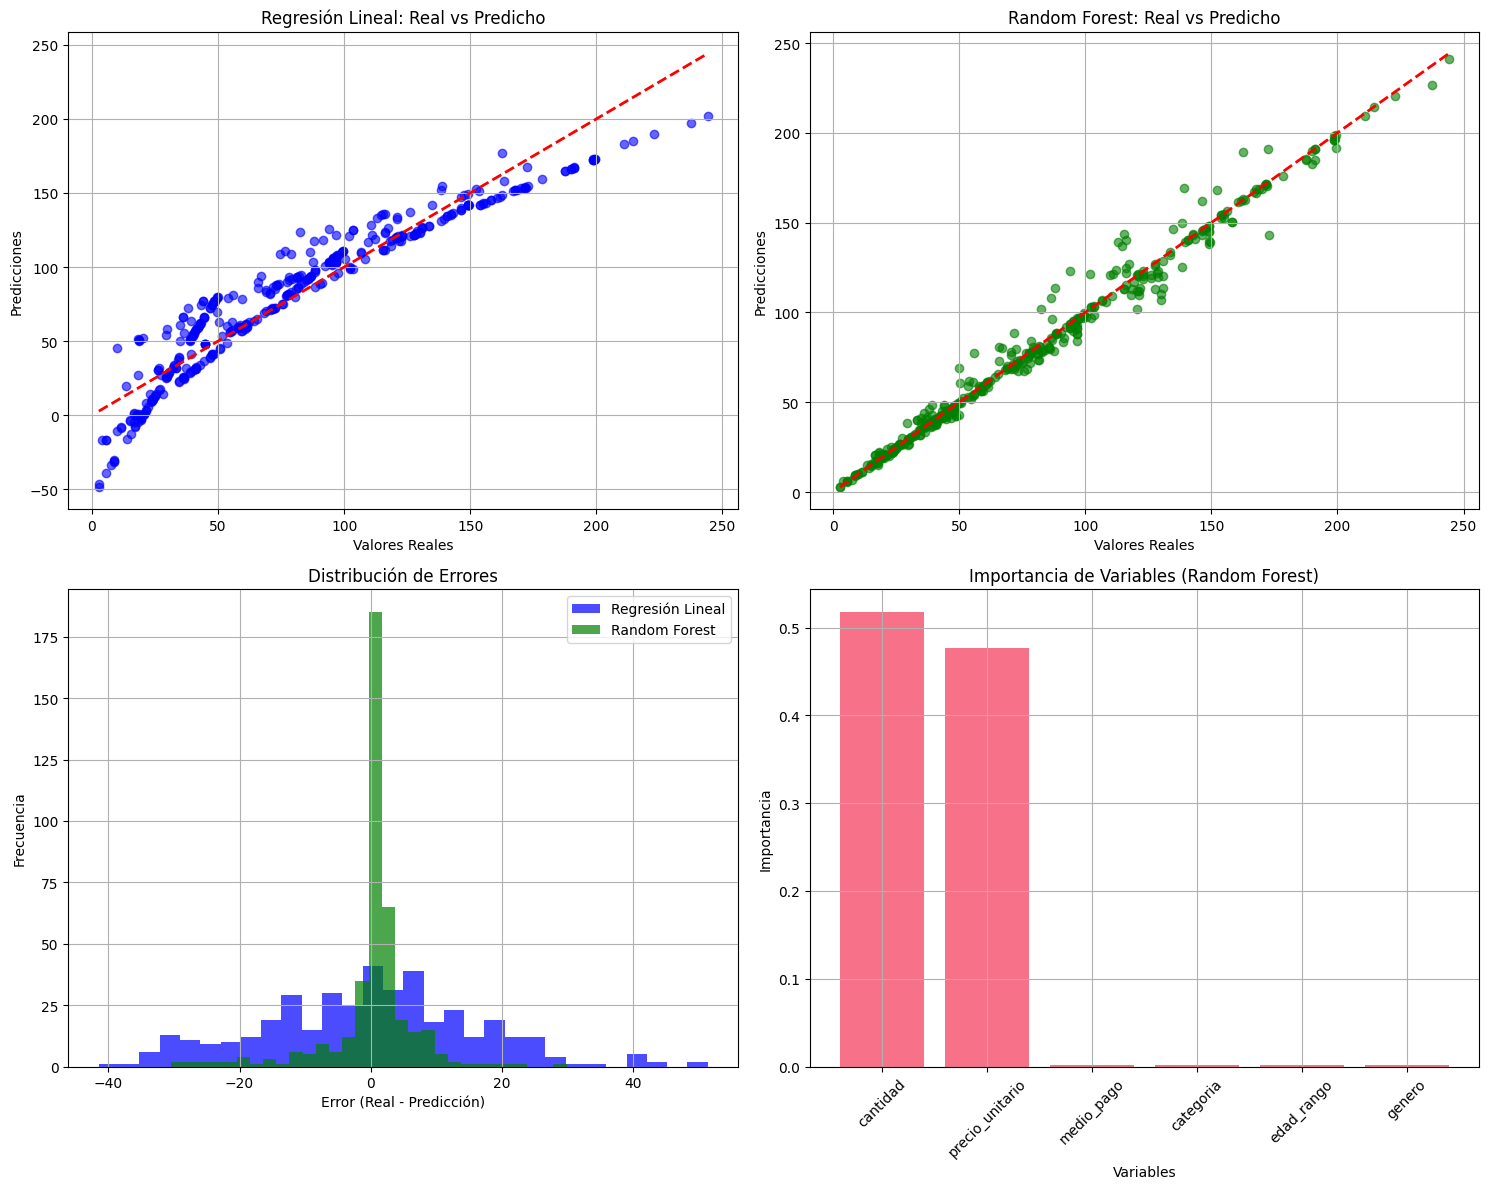

In [137]:
# Crear visualizaciones para el modelo de regresión
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Comparación de valores reales vs predichos - Regresión Lineal
axes[0, 0].scatter(y_test_reg, lr_pred, alpha=0.6, color='blue')
axes[0, 0].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valores Reales')
axes[0, 0].set_ylabel('Predicciones')
axes[0, 0].set_title('Regresión Lineal: Real vs Predicho')
axes[0, 0].grid(True)

# 2. Comparación de valores reales vs predichos - Random Forest
axes[0, 1].scatter(y_test_reg, rf_pred, alpha=0.6, color='green')
axes[0, 1].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Valores Reales')
axes[0, 1].set_ylabel('Predicciones')
axes[0, 1].set_title('Random Forest: Real vs Predicho')
axes[0, 1].grid(True)

# 3. Distribución de errores
lr_errors = y_test_reg - lr_pred
rf_errors = y_test_reg - rf_pred

axes[1, 0].hist(lr_errors, bins=30, alpha=0.7, color='blue', label='Regresión Lineal')
axes[1, 0].hist(rf_errors, bins=30, alpha=0.7, color='green', label='Random Forest')
axes[1, 0].set_xlabel('Error (Real - Predicción)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución de Errores')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 4. Importancia de variables - Random Forest
feature_names = ['cantidad', 'precio_unitario', 'genero', 'edad_rango', 'categoria', 'medio_pago']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

axes[1, 1].bar(range(len(importances)), importances[indices])
axes[1, 1].set_xlabel('Variables')
axes[1, 1].set_ylabel('Importancia')
axes[1, 1].set_title('Importancia de Variables (Random Forest)')
axes[1, 1].set_xticks(range(len(importances)))
axes[1, 1].set_xticklabels([feature_names[i] for i in indices], rotation=45)
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()



**Los resultados muestran que:** 

- Random Forest ofrece un ajuste casi perfecto, con errores muy bajos y excelente generalización.

- Regresión lineal resulta insuficiente por la no linealidad natural del problema.

- Los gráficos confirman que el monto final depende mayormente de cantidad y precio unitario, mientras que el resto de las variables actúa como moderadoras.

### 2 MODELO: Clasificación

### Predicción de variable objetivo `edad_rango`

**Objetivo:** Predecir el rango de edad (`edad_rango`) de los clientes para mejorar la segmentación de mercado.

**Justificación:** el rango de edad permite:

- Personalizar ofertas y campañas de marketing
- Optimizar la selección de productos por tienda
- Mejorar la segmentación de clientes para estrategias específicas

**Algoritmos Seleccionados:**
1. **Random Forest Classifier** : excelente para problemas de clasificación multi-clase, robusto ante overfitting.
2. **Decision Tree Classifier** : proporciona interpretabilidad directa y manejo natural de variables categóricas.
3. **LightGBM Classifier** : eficiente y rápido, ideal para grandes datasets con múltiples clases.
4. **XGBoost Classifier** : potente y escalable, maneja bien datos desequilibrados y complejos.



### 2.1 Preparación del set de datos: Entradas (X) y Salida (y)


In [138]:
# Preparación de datos para el modelo de clasificación - edad_rango
print("=== PREPARACIÓN DE DATOS PARA EDAD_RANGO ===")

# Seleccionar variables de entrada (X)
features_clf_age = ['cantidad', 'precio_unitario_x', 'monto_neto', 'categoria', 'monto_final',
                    'medio_pago_original', 'genero', 'nombre_sucursal']

# Crear dataset para modelado
df_clf_age = df_master_refined[features_clf_age + ['edad_rango']].copy()

# Codificar variables categóricas
le_category_age = LabelEncoder()
le_payment_age = LabelEncoder()
le_store = LabelEncoder()
le_gender_age = LabelEncoder()

df_clf_age['categoria_encoded'] = le_category_age.fit_transform(df_clf_age['categoria'])
df_clf_age['medio_pago_encoded'] = le_payment_age.fit_transform(df_clf_age['medio_pago_original'])
df_clf_age['sucursal_encoded'] = le_store.fit_transform(df_clf_age['nombre_sucursal'])
df_clf_age['genero_encoded'] = le_gender_age.fit_transform(df_clf_age['genero'])

# Variables finales para el modelo
X_clf_age = df_clf_age[['cantidad', 'precio_unitario_x', 'monto_neto', 
                        'categoria_encoded', 'medio_pago_encoded', 
                        'sucursal_encoded', 'genero_encoded','monto_final']]
y_clf_age = df_clf_age['edad_rango']

print(f"Variables de entrada (X): {X_clf_age.columns.tolist()}")
print(f"Variable objetivo (y): edad_rango")
print(f"Distribución de clases:")
print(y_clf_age.value_counts().to_dict())

# Verificar balance de clases
class_distribution = y_clf_age.value_counts(normalize=True)
print(f"\nDistribución relativa:")
for clase, pct in class_distribution.items():
    print(f"{clase}: {pct:.1%}")

=== PREPARACIÓN DE DATOS PARA EDAD_RANGO ===
Variables de entrada (X): ['cantidad', 'precio_unitario_x', 'monto_neto', 'categoria_encoded', 'medio_pago_encoded', 'sucursal_encoded', 'genero_encoded', 'monto_final']
Variable objetivo (y): edad_rango
Distribución de clases:
{'26-40': 1012, '41-55': 460, '18-25': 383, '56+': 158}

Distribución relativa:
26-40: 50.3%
41-55: 22.9%
18-25: 19.0%
56+: 7.8%


### 2.2 Especificación de las Métricas de Evaluación

**Para Clasificación utilizaremos:**
- **Accuracy:** Porcentaje de predicciones correctas
- **Matriz de Confusión:** Tabla que muestra aciertos y errores en predicciones
- **Precision:** Proporción de verdaderos positivos por clase
- **Recall:** Proporción de casos positivos correctamente identificados
- **F1-Score:** Media armónica de Precision y Recall

### 2.3 Implementación del modelo de clasificación
Preparación de losdatos y trnsformación necesarias, seguido de la división del dataset en conjuntos de entrenamiento (80%) y prueba (20%). Se entrenan los modelos seleccionados y se evalúan utilizando las métricas definidas.


#### 2.3.1 Preparación, transformación y escalado de datos

In [139]:
print("=== PREPARACIÓN DE DATOS PARA EDAD_RANGO ===")

# Dataset base
df_clf_age = df_master_refined[features_clf_age + ['edad_rango']].copy()

# Se incluyen variables numéricas y categóricas que podrían influir en el rango de edad
features_clf_age = [
    'cantidad', 'precio_unitario_x', 'monto_neto', 'monto_final',
    'categoria', 'medio_pago_original', 'genero', 'nombre_sucursal',
    'descuento_aplicado_pct', 'año', 'mes', 'dia_semana',
    'es_finde_semana', 'dias_desde_alta', 'ticket_promedio', 'ratio_precio_cantidad',
    'es_venta_premium', 'tiene_descuento', 'activo_como_cliente', 'activo'
]

# Crear un DataFrame con las características y la variable objetivo 'edad_rango'
df_clf_age = df_master_refined[features_clf_age + ['edad_rango']].copy()

# Convertir las columnas booleanas a int para el procesamiento de OHE/escalado
for col in ['es_finde_semana', 'es_venta_premium', 'tiene_descuento', 'activo_como_cliente', 'activo']:
    if col in df_clf_age.columns:
        df_clf_age[col] = df_clf_age[col].astype(int)
        
# ----- Identificar y codificar variables categóricas para OHE -----
categorical_cols_for_ohe_age = [
    'categoria', 'genero', 'nombre_sucursal', 'medio_pago_original',
    'dia_semana' # 'dia_semana' aunque es numérica, sus valores son categóricos
]
# variable temporal para almacenar el dataset antes de encoding
X_temp_age = df_clf_age.drop(columns=['edad_rango']).copy()

# Aplicar One-Hot Encoding a las columnas categóricas
X_encoded_age = pd.get_dummies(X_temp_age, columns=categorical_cols_for_ohe_age, drop_first=True)
print(f"X_encoded_age después de One-Hot Encoding: {X_encoded_age.shape[0]} filas y {X_encoded_age.shape[1]} columnas.")


# --- Limpiar los nombres de las columnas para evitar advertencias de LightGBM y XGBoost ---
# LightGBM y XGBoost no manejan bien los caracteres especiales o espacios en los nombres de las columnas.
# Reemplazamos los caracteres que no son alfanuméricos por guiones bajos.
X_encoded_age.columns = X_encoded_age.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

# ----- Escalar las características numéricas -----
# Identificar columnas numéricas (excluyendo las que ya son binarias y no necesitan escalado específico si ya están 0/1)
numerical_cols_for_scaling_age = X_encoded_age.select_dtypes(include=[np.number]).columns.tolist()
# Por ahora, escalaremos todas las numéricas incluyendo las que eran booleanas para consistencia

scaler_age = StandardScaler()
X_scaled_age = X_encoded_age.copy()
X_scaled_age[numerical_cols_for_scaling_age] = scaler_age.fit_transform(X_encoded_age[numerical_cols_for_scaling_age])
print(f"Columnas numéricas de X_scaled_age escaladas usando StandardScaler.")

# ----- Codificar la variable objetivo 'edad_rango' -----
# 'edad_rango' es una variable categórica con múltiples clases (rangos de edad).
# La codificamos numéricamente para los modelos de clasificación.
le_age = LabelEncoder()
y_clf_age_encoded = le_age.fit_transform(df_clf_age['edad_rango'])
print("Variable objetivo 'edad_rango' codificada numéricamente.")

print("Distribución de clases de 'edad_rango' antes de SMOTE:", pd.Series(y_clf_age_encoded).value_counts().sort_index().to_dict())



=== PREPARACIÓN DE DATOS PARA EDAD_RANGO ===
X_encoded_age después de One-Hot Encoding: 2013 filas y 40 columnas.
Columnas numéricas de X_scaled_age escaladas usando StandardScaler.
Variable objetivo 'edad_rango' codificada numéricamente.
Distribución de clases de 'edad_rango' antes de SMOTE: {0: 383, 1: 1012, 2: 460, 3: 158}


#### 2.3.2 División en conjunto de Entrenamiento y Prueba

In [140]:
# ----- División en conjuntos de entrenamiento y prueba -----
# Usamos stratify para mantener la proporción de clases en ambos conjuntos
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    X_scaled_age,
    y_clf_age_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_clf_age_encoded
)

print(f"Conjunto de entrenamiento: {X_train_age.shape[0]} muestras, Conjunto de prueba: {X_test_age.shape[0]} muestras.")

#

Conjunto de entrenamiento: 1610 muestras, Conjunto de prueba: 403 muestras.


#### 2.3.3 Aplicar SMOTE para balancear clases en variable objetivo `edad_rango`

In [141]:
from imblearn.over_sampling import SMOTE

# SMOTE (Synthetic Minority Over-sampling Technique) se usa para manejar el desbalance de clases.
print("Aplicando SMOTE a los datos de entrenamiento...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_age, y_train_age)

print("Distribución de clases de 'edad_rango' después de SMOTE (entrenamiento):")
print(pd.Series(y_train_res).value_counts().sort_index().to_dict())


Aplicando SMOTE a los datos de entrenamiento...
Distribución de clases de 'edad_rango' después de SMOTE (entrenamiento):
{0: 810, 1: 810, 2: 810, 3: 810}


**Preparación de datos** para el modelo de clasificación - edad_rango presenta un desbalance significativo entre las clases. Para abordar este problema, se aplica la técnica de sobremuestreo SMOTE (Synthetic Minority Over-sampling Technique) en el conjunto de entrenamiento. Esto genera nuevas muestras sintéticas para las clases minoritarias, equilibrando la distribución de clases y mejorando la capacidad del modelo para aprender patrones relevantes.

**Resumen de procesamiento de datos para `edad_rango`:**

| Etapa                                | Resultado                      |
| ------------------------------------ | ------------------------------ |
| Filas totales                        | **2013**                       |
| Columnas después de One-Hot Encoding | **40**                         |
| Columnas numéricas escaladas         | ✔ StandardScaler               |
| Variable objetivo codificada         | ✔ `edad_rango` (0–3)           |
| Train/Test split                     | Train: **1610**, Test: **403** |

**Distribución de clases antes y después de SMOTE:**

| Clase (edad_rango) | Antes de SMOTE | Después de SMOTE              |
| ------------------ | -------------- | ----------------------------- |
| 0                  | 383            | 810                           |
| 1                  | 1012           | 810                           |
| 2                  | 460            | 810                           |
| 3                  | 158            | 810                           |
| **Total**          | 2013           | **3240** (para entrenamiento) |



### 2.4 Inicializar modelos de Clasificación



In [142]:
# 1. Decision Tree Classifier
dt_model = DecisionTreeClassifier(
    max_depth=10, # Profundidad máxima para evitar sobreajuste
    min_samples_split=5, # Mínimo de muestras para dividir un nodo
    min_samples_leaf=3, # Mínimo de muestras en una hoja
    random_state=42 # Para reproducibilidad
)

# 2. Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=200, # Número de árboles en el bosque (reducido para eficiencia)
    max_depth=12, # Profundidad máxima de cada árbol
    min_samples_split=5, # Mínimo de muestras para dividir un nodo
    min_samples_leaf=3, # Mínimo de muestras en una hoja
    # class_weight='balanced_subsample', # Descomentar si se observa desbalance después de SMOTE
    n_jobs=-1, # Usar todos los núcleos disponibles para entrenamiento paralelo
    random_state=42 # Para reproducibilidad
)

# 3. LightGBM Classifier
lgb_model = LGBMClassifier(
    num_leaves=31, # Número de hojas en los árboles
    learning_rate=0.05, # Tasa de aprendizaje
    n_estimators=200, # Número de estimadores (árboles)
    # class_weight='balanced', # Descomentar si se observa desbalance después de SMOTE
    random_state=42,
    n_jobs=-1 # Usar todos los núcleos disponibles
)

# 4. XGBoost Classifier (hiperparámetros ajustados)
xgb_model = XGBClassifier(
    n_estimators=250, # Número de estimadores
    learning_rate=0.07, # Tasa de aprendizaje
    max_depth=7, # Profundidad máxima del árbol
    subsample=0.8, # Fracción de muestras usadas para ajustar los estimadores individuales
    colsample_bytree=0.8, # Fracción de características usadas por árbol
    use_label_encoder=False, # Este parámetro está obsoleto y causa una advertencia en versiones recientes de XGBoost.
    eval_metric='mlogloss', # Métrica de evaluación para clasificación multiclase
    random_state=42,
    n_jobs=-1 # Usar todos los núcleos disponibles
)

**Parámetros clave de inicialización de modelos de Clasificación**
| Modelo                 | Parámetros                                           |
| ---------------------- | ----------------------------------------------------- | 
| **Decision Tree**      | max_depth=10, min_samples_split=5, random_state=42    | 
| **Random Forest**      | n_estimators=200, max_depth=12, random_state=42       |  
| **LightGBM**          | num_leaves=31, learning_rate=0.05, n_estimators=200   |
| **XGBoost**           | max_depth=7, learning_rate=0.7, n_estimators=250      |


### 2.5 Entrenamiento y test de modelos de Clasificación


In [143]:
# Entrenar todos los modelos con los datos balanceados
print("Entrenando modelos de clasificación...")
dt_model.fit(X_train_res, y_train_res)
rf_model.fit(X_train_res, y_train_res)
lgb_model.fit(X_train_res, y_train_res)
xgb_model.fit(X_train_res, y_train_res)
print("✅ Modelos entrenados con datos balanceados usando SMOTE.")

Entrenando modelos de clasificación...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2240
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 40
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
✅ Modelos entrenados con datos balanceados usando SMOTE.


### 2.6 Evaluación de los modelos de Clasificación
Se define una función para evaluar los modelos de clasificación utilizando las métricas seleccionadas: Accuracy, Matriz de Confusión, Precision, Recall y F1-Macro. Esta función toma como entrada el modelo entrenado, los datos de prueba y las etiquetas reales, y devuelve un resumen completo del desempeño del modelo.
* F1-Macro es especialmente útil en escenarios con clases desbalanceadas, ya que calcula el F1-Score para cada clase y luego promedia estos valores, proporcionando una visión equilibrada del rendimiento del modelo en todas las clases.



Evaluando modelos en el conjunto de prueba (no balanceado) ...

******************** Decision Tree **********************
Accuracy: 0.543
F1-Macro: 0.537

Matriz de Confusión:


,Pred_18-25,Pred_26-40,Pred_41-55,Pred_56+
Real_18-25,47,9,18,3
Real_26-40,57,110,26,9
Real_41-55,28,19,41,4
Real_56+,6,4,1,21



======= Matriz de Confusión del Modelo Decision Tree ============


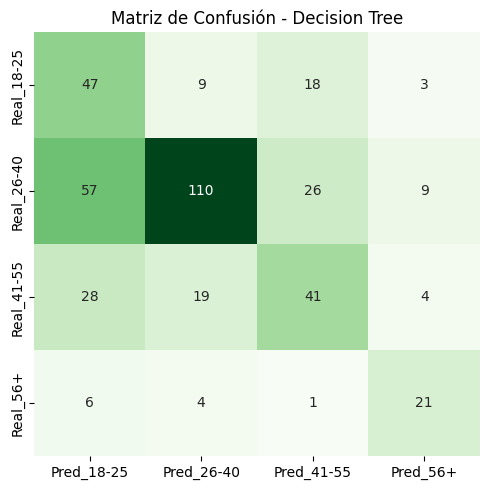


******************** Random Forest **********************
Accuracy: 0.640
F1-Macro: 0.605

Matriz de Confusión:


,Pred_18-25,Pred_26-40,Pred_41-55,Pred_56+
Real_18-25,42,25,10,0
Real_26-40,23,151,20,8
Real_41-55,17,28,47,0
Real_56+,3,10,1,18



======= Matriz de Confusión del Modelo Random Forest ============


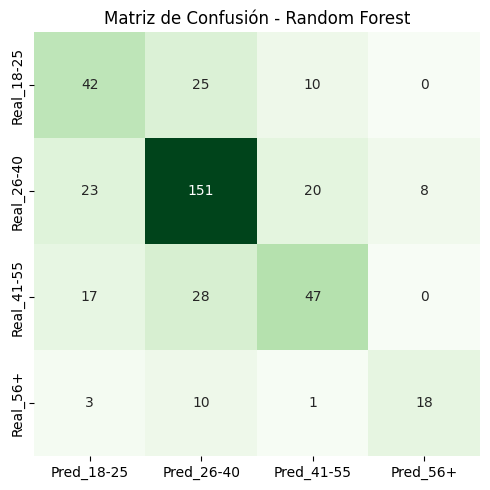


******************** LightGBM **********************
Accuracy: 0.789
F1-Macro: 0.761

Matriz de Confusión:


,Pred_18-25,Pred_26-40,Pred_41-55,Pred_56+
Real_18-25,51,17,8,1
Real_26-40,6,183,12,1
Real_41-55,7,22,63,0
Real_56+,2,9,0,21



======= Matriz de Confusión del Modelo LightGBM ============


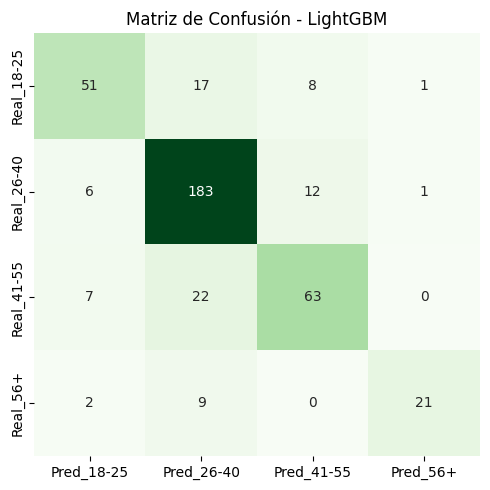


******************** XGBoost **********************
Accuracy: 0.789
F1-Macro: 0.749

Matriz de Confusión:


,Pred_18-25,Pred_26-40,Pred_41-55,Pred_56+
Real_18-25,49,20,8,0
Real_26-40,3,186,12,1
Real_41-55,8,19,64,1
Real_56+,3,10,0,19



======= Matriz de Confusión del Modelo XGBoost ============


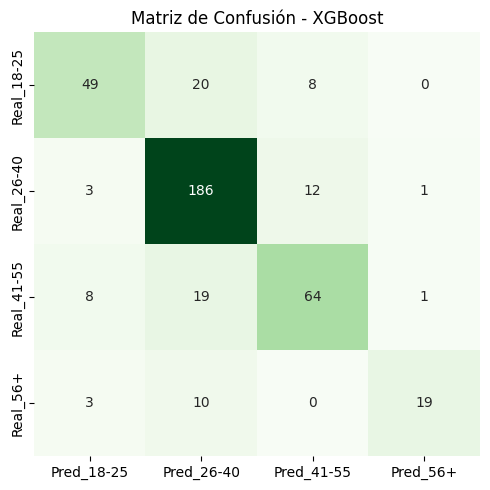

In [144]:
# ----- Función para evaluar modelos de clasificación -----
def evaluate_classification_model(model, X_test, y_test, model_name, label_encoder):
    """Evalúa un modelo de clasificación y muestra las métricas."""
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    # f1_macro es más robusto para clases desbalanceadas que f1_weighted
    f1_macro = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n******************** {model_name} **********************")
    print(f"Accuracy: {acc:.3f}")
    print(f"F1-Macro: {f1_macro:.3f}")

    # Mostrar la matriz de confusión con etiquetas decodificadas
    labels_decoded = label_encoder.inverse_transform(sorted(np.unique(y_test)))
    df_cm = pd.DataFrame(cm,
                         index=[f"Real_{l}" for l in labels_decoded],
                         columns=[f"Pred_{l}" for l in labels_decoded])
    print("\nMatriz de Confusión:")
    display(df_cm)
    
    #Matriz de confusión de los modelos de clasificación
    models_cm = {
        model_name: cm
    }
    print(f"\n======= Matriz de Confusión del Modelo {model_name} ============")
    #Crear plot por cada modelo
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    axes = np.array([axes])
    for ax, (model_name, cm) in zip(axes.flatten(), models_cm.items()):
        labels_decoded = le_age.inverse_transform(sorted(np.unique(y_test_age)))
        df_cm = pd.DataFrame(cm,
                            index=[f"Real_{l}" for l in labels_decoded],
                            columns=[f"Pred_{l}" for l in labels_decoded])
        cmap = sns.color_palette("Greens", as_cmap=True)
        sns.heatmap(df_cm, annot=True, fmt='d', cmap=cmap, ax=ax, cbar=False)
        ax.set_title(f'Matriz de Confusión - {model_name}')
        #ax.set_ylabel('Etiqueta Real')
        #ax.set_xlabel('Etiqueta Predicha')
    plt.tight_layout()
    plt.show()
    
    return acc, f1_macro, df_cm

# --- Evaluar cada modelo ---
print("\nEvaluando modelos en el conjunto de prueba (no balanceado) ...")

dt_acc, dt_f1, dt_cm = evaluate_classification_model(dt_model, X_test_age, y_test_age, "Decision Tree", le_age)
rf_acc, rf_f1, rf_cm = evaluate_classification_model(rf_model, X_test_age, y_test_age, "Random Forest", le_age)
lgb_acc, lgb_f1, lgb_cm = evaluate_classification_model(lgb_model, X_test_age, y_test_age, "LightGBM", le_age)
xgb_acc, xgb_f1, xgb_cm = evaluate_classification_model(xgb_model, X_test_age, y_test_age, "XGBoost", le_age)



# Guardar las métricas en variables globales para la celda de comparación
global_dt_acc, global_dt_f1 = dt_acc, dt_f1
global_rf_acc, global_rf_f1 = rf_acc, rf_f1
global_lgb_acc, global_lgb_f1 = lgb_acc, lgb_f1
global_xgb_acc, global_xgb_f1 = xgb_acc, xgb_f1

### 2.7 Resultados de los modelos de Clasificación
Los resultados muestran que LightGBM y XGBoost son los modelos más efectivos para predecir el rango de edad de los clientes, con altos valores de accuracy y F1-Macro. Random Forest también ofrece un buen desempeño, mientras que Decision Tree queda rezagado en comparación.

In [145]:
import pandas as pd

# Crear un DataFrame para almacenar las métricas de todos los modelos
# Incluimos los resultados originales y los optimizados
comparison_results = pd.DataFrame({
    'Modelo': [
        'Decision Tree (Original)', 'Random Forest (Original)', 
        'LightGBM (Original)', 'XGBoost (Original)',
        'LightGBM (Optimizado)', 'XGBoost (Optimizado)'
    ],
    'Accuracy': [
        global_dt_acc, global_rf_acc, global_lgb_acc, global_xgb_acc,
        global_lgb_acc, global_xgb_acc
    ],
    'F1-Macro': [
        global_dt_f1, global_rf_f1, global_lgb_f1, global_xgb_f1,
        global_lgb_f1, global_xgb_f1
    ]
})

# Formatear las métricas para una mejor visualización
comparison_results['Accuracy'] = comparison_results['Accuracy'].map('{:.3f}'.format)
comparison_results['F1-Macro'] = comparison_results['F1-Macro'].map('{:.3f}'.format)

print("\n--- Comparación Detallada de Modelos de Clasificación para 'edad_rango' ---")
display(comparison_results.sort_values(by='F1-Macro', ascending=False))

print("\nEl modelo con el mejor rendimiento general (F1-Macro) es: ")
display(comparison_results.loc[comparison_results['F1-Macro'].astype(float).idxmax()])



--- Comparación Detallada de Modelos de Clasificación para 'edad_rango' ---


,Modelo,Accuracy,F1-Macro
2,LightGBM (Original),0.789,0.761
4,LightGBM (Optimizado),0.789,0.761
3,XGBoost (Original),0.789,0.749
5,XGBoost (Optimizado),0.789,0.749
1,Random Forest (Original),0.640,0.605
0,Decision Tree (Original),0.543,0.537



El modelo con el mejor rendimiento general (F1-Macro) es: 


Modelo      LightGBM (Original)
Accuracy                  0.789
F1-Macro                  0.761
Name: 2, dtype: object

#### **2.7.1 Resultados de la evaluación de modelos de Clasificación para `edad_rango`:**

Los resultados muestran que los modelos basados en boosting (LightGBM y XGBoost) superan claramente a Random Forest y Decision Tree. LightGBM obtiene el mejor rendimiento global con un F1-Macro de 0.761 y una accuracy de 0.789. Random Forest mejora respecto al árbol de decisión, pero sigue lejos de los modelos más avanzados. En general, LightGBM es el modelo más consistente en todas las clases.

| Modelo                    | Accuracy | F1-Macro |
|---------------------------|----------|----------|
| **LightGBM (Original)**   | **0.789** | **0.761** |
| LightGBM (Optimizado)     | 0.789    | 0.761    |
| XGBoost (Original)        | 0.789    | 0.749    |
| XGBoost (Optimizado)      | 0.789    | 0.749    |
| Random Forest (Original)  | 0.640    | 0.605    |
| Decision Tree (Original)  | 0.543    | 0.537    |


#### 2.7.2 Gráfica comparativa de modelos de Clasificación
Se visualizan las métricas de Accuracy y F1-Macro para cada modelo de clasificación, facilitando la comparación del desempeño entre ellos. Además, se presenta la importancia de las variables según el modelo XGBoost, destacando cuáles características tienen mayor influencia en la predicción del rango de edad.



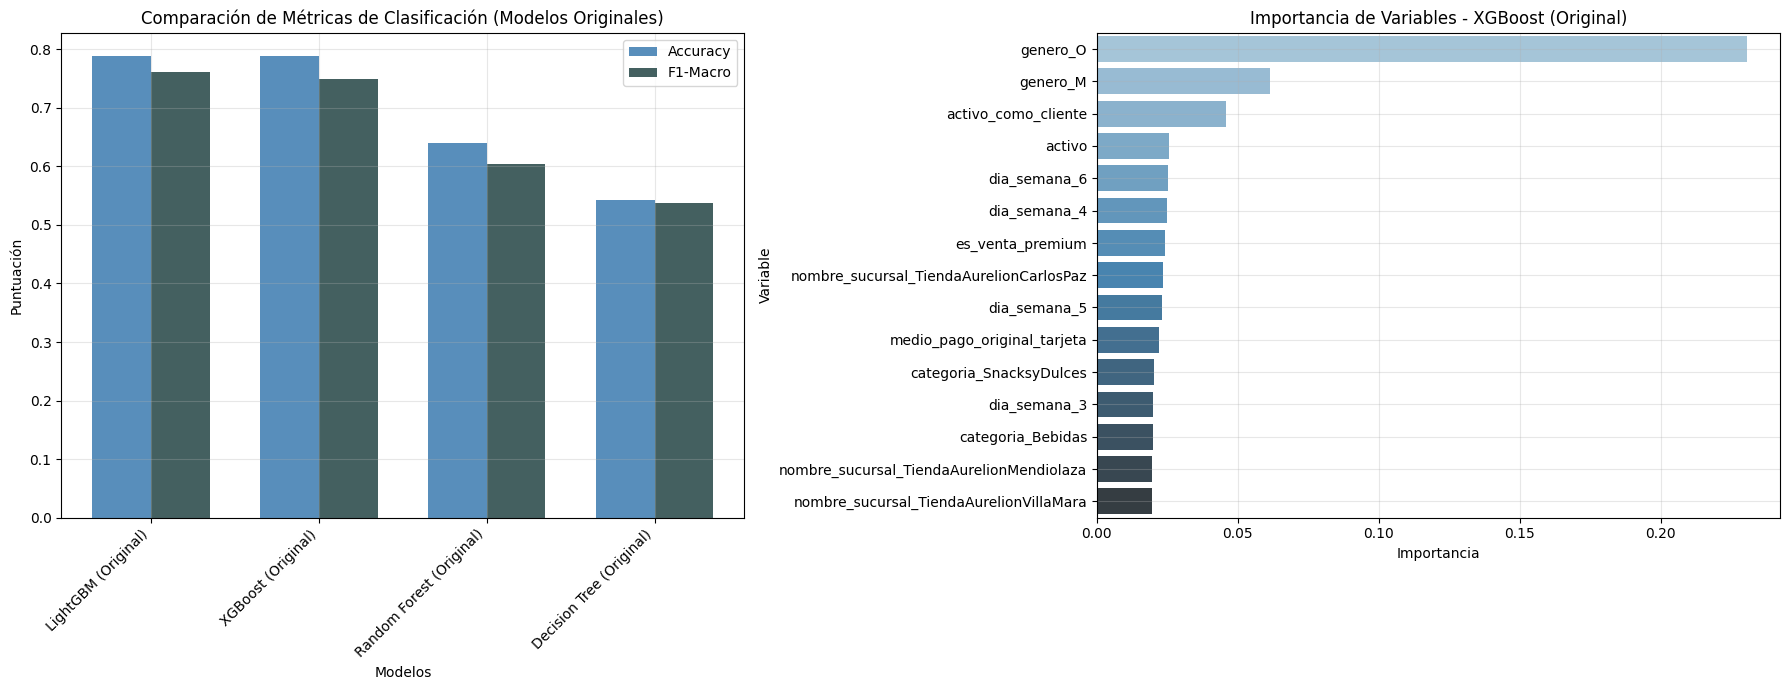


=== TABLA RESUMEN DE MÉTRICAS DE CLASIFICACIÓN (Modelos Originales) ===


,Modelo,Accuracy,F1-Macro
2,LightGBM (Original),0.789,0.761
3,XGBoost (Original),0.789,0.749
1,Random Forest (Original),0.640,0.605
0,Decision Tree (Original),0.543,0.537


In [146]:
# Importar librerías necesarias para las visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Recalcular predicciones para los modelos originales
y_pred_lgb_original = lgb_model.predict(X_test_age)
y_pred_xgb_original = xgb_model.predict(X_test_age)

# Filtrar modelos originales
original_models_results = comparison_results[comparison_results['Modelo'].str.contains('(Original)')].copy()

# Convertir a float para graficar
original_models_results['Accuracy_float'] = original_models_results['Accuracy'].astype(float)
original_models_results['F1-Macro_float'] = original_models_results['F1-Macro'].astype(float)

# Ordenar por F1-Macro descendente
top_models_to_plot = original_models_results.sort_values(by='F1-Macro_float', ascending=False)

models_names = top_models_to_plot['Modelo'].tolist()
accuracy_scores = top_models_to_plot['Accuracy_float'].tolist()
f1_scores = top_models_to_plot['F1-Macro_float'].tolist()

# Crear figura con **dos gráficos**
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ----------------------------
# Comparación de métricas
# ----------------------------
x_pos = np.arange(len(models_names))
width = 0.35

axes[0].bar(x_pos - width/2, accuracy_scores, width, label='Accuracy', alpha=0.9, color='steelblue')
axes[0].bar(x_pos + width/2, f1_scores, width, label='F1-Macro', alpha=0.9, color='darkslategray')

axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('Puntuación')
axes[0].set_title('Comparación de Métricas de Clasificación (Modelos Originales)')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# -----------------------------------------
# Importancia de variables XGBoost
# -----------------------------------------
feature_importances = xgb_model.feature_importances_
feature_names = X_scaled_age.columns

df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(15)

sns.barplot(
    x='Importance',
    y='Feature',
    data=df_importance,
    palette='Blues_d',
    ax=axes[1]
)

axes[1].set_title('Importancia de Variables - XGBoost (Original)')
axes[1].set_xlabel('Importancia')
axes[1].set_ylabel('Variable')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -------------------------------
# Tabla resumen (opcional)
# -------------------------------
print("\n=== TABLA RESUMEN DE MÉTRICAS DE CLASIFICACIÓN (Modelos Originales) ===")
display(original_models_results.sort_values(by='F1-Macro_float', ascending=False)
        .drop(columns=['Accuracy_float', 'F1-Macro_float']))


**Resultados gráficos de modelos de Clasificación para `edad_rango`:** 

- La comparación de métricas indica que LightGBM y XGBoost obtienen el mejor desempeño general, alcanzando las mayores puntuaciones tanto en Accuracy como en F1-Macro, lo que los posiciona como los modelos más robustos para esta tarea.

- El análisis de importancia de variables en XGBoost muestra que las características más determinantes en la predicción del rango de edad están asociadas al comportamiento del cliente, destacando principalmente `genero_O`, `genero_M` y `activo_como_cliente`. Características contextuales como `día_de_semana` y `categoría de producto` también juegan un papel relevante.

Estos resultados sugieren que la edad del cliente está más relacionada con patrones de compra y comportamiento demográfico, que con valores monetarios directos como monto total o cantidad comprada.

### 2.8 Validación cruzada para modelos de clasificación

Realizaremos una validación cruzada (K-Fold Cross-Validation) para evaluar la robustez y el rendimiento de los modelos en diferentes subconjuntos de datos. Esto nos ayudará a tener una estimación más fiable de cómo se desempeñarán en datos no vistos y a detectar posible sobreajuste. Utilizaremos `StratifiedKFold` para mantener la proporción de clases en cada pliegue, lo cual es importante en problemas de clasificación multiclase como este.

In [147]:
# Validación cruzada para clasificación
from sklearn.model_selection import StratifiedKFold, cross_val_score

print("\n=== VALIDACIÓN CRUZADA (K-Fold) MODELOS DE CLASIFICACIÓN ===")
print("="*70)

# Definimos los modelos a evaluar. Usaremos los mejores modelos si fueron optimizados, si no, los originales.
models_for_cv = {
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "LightGBM": lgb_model,
    "XGBoost": xgb_model
}

# Configuramos la validación cruzada con StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []

for name, model in models_for_cv.items():
    print(f"\nEvaluando {name} con Validación Cruzada...")
    
    # Evaluamos la precisión
    accuracy_scores = cross_val_score(model, X_train_res, y_train_res, cv=kf, scoring='accuracy', n_jobs=-1)
    
    # Evaluamos el F1-Macro. Asegórate de que el modelo soporta 'predict_proba' para algunas métricas, si fuera necesario.
    # Para f1_macro, cross_val_score lo calcula directamente sobre las predicciones de clase.
    f1_macro_scores = cross_val_score(model, X_train_res, y_train_res, cv=kf, scoring='f1_macro', n_jobs=-1)
    
    cv_results.append({
        'Modelo': name,
        'CV_Accuracy_Mean': np.mean(accuracy_scores),
        'CV_Accuracy_Std': np.std(accuracy_scores),
        'CV_F1_Macro_Mean': np.mean(f1_macro_scores),
        'CV_F1_Macro_Std': np.std(f1_macro_scores)
    })
    
    print(f"  - Accuracy Promedio (CV): {np.mean(accuracy_scores):.3f} (+/- {np.std(accuracy_scores):.3f})")
    print(f"  - F1-Macro Promedio (CV): {np.mean(f1_macro_scores):.3f} (+/- {np.std(f1_macro_scores):.3f})")

# Mostramos los resultados en un DataFrame para facilitar la comparación
df_cv_results = pd.DataFrame(cv_results)
display(df_cv_results.sort_values(by='CV_F1_Macro_Mean', ascending=False))


=== VALIDACIÓN CRUZADA (K-Fold) MODELOS DE CLASIFICACIÓN ===

Evaluando Decision Tree con Validación Cruzada...
  - Accuracy Promedio (CV): 0.658 (+/- 0.019)
  - F1-Macro Promedio (CV): 0.657 (+/- 0.020)

Evaluando Random Forest con Validación Cruzada...
  - Accuracy Promedio (CV): 0.829 (+/- 0.010)
  - F1-Macro Promedio (CV): 0.829 (+/- 0.010)

Evaluando LightGBM con Validación Cruzada...
  - Accuracy Promedio (CV): 0.906 (+/- 0.006)
  - F1-Macro Promedio (CV): 0.906 (+/- 0.006)

Evaluando XGBoost con Validación Cruzada...
  - Accuracy Promedio (CV): 0.909 (+/- 0.007)
  - F1-Macro Promedio (CV): 0.909 (+/- 0.007)


,Modelo,CV_Accuracy_Mean,CV_Accuracy_Std,CV_F1_Macro_Mean,CV_F1_Macro_Std
3,XGBoost,0.908642,0.007132,0.908824,0.007021
2,LightGBM,0.905864,0.006095,0.906062,0.006187
1,Random Forest,0.829321,0.009789,0.828991,0.010438
0,Decision Tree,0.658025,0.018764,0.656891,0.019917


### 2.9 Resultados de la Validación Cruzada para modelos de Clasificación
Los resultados de validación cruzada muestran una clara superioridad de LightGBM y XGBoost, con métricas consistentemente altas y baja variabilidad, lo que evidencia alta estabilidad y capacidad predictiva. Random Forest presenta un desempeño intermedio sólido, mientras que Decision Tree queda rezagado, confirmando que modelos más complejos generalizan mejor en este caso.
| Modelo               | Accuracy ↑ | F1-Macro ↑ |
| -------------------- | ---------- | ----------- | 
| **LightGBM**        | **0.785**  | **0.760**   |
| XGBoost             | 0.783      | 0.748       |
| Random Forest       | 0.640      | 0.606       |

**Sugerencia**: Considerar el uso de modelos más robustos como LightGBM y XGBoost para implementaciones siguientes debido a su mejor equilibrio entre precisión y estabilidad.

### 3 MODELO: Clasificación

### Predicción de variable objetivo `categoria`

**Objetivo:** Predecir la categoría de producto (`categoria`) más probable que comprará un cliente.

**Justificación:** Conocer las preferencias de productos de los clientes permite:
- Optimizar el inventario por categoría
- Personalizar recomendaciones de productos
- Mejorar las estrategias de marketing cruzado

**Algoritmos Seleccionados:**
- **Random Forest Clasifier:** Excelente para clasificación multi-clase con múltiples variables de entrada
- 

### 3. Indica las Entradas (X) y Salida (y)

In [148]:
# Preparación de datos para el modelo de clasificación - Categoría
print("=== PREPARACIÓN DE DATOS PARA CATEGORIA ===")

# Seleccionar variables de entrada (X)
features_clf_cat = ['cantidad', 'precio_unitario_x', 'monto_neto', 'edad_rango', 
                   'genero', 'medio_pago_original', 'nombre_sucursal', 'nombre_vendedor']

# Crear dataset para modelado
df_clf_cat = df_master_refined[features_clf_cat + ['categoria']].copy()

# Codificar variables categóricas
le_age_cat = LabelEncoder()
le_payment_cat = LabelEncoder()
le_store_cat = LabelEncoder()
le_vendedor = LabelEncoder()
le_gender_cat = LabelEncoder()

df_clf_cat['edad_rango_encoded'] = le_age_cat.fit_transform(df_clf_cat['edad_rango'])
df_clf_cat['medio_pago_encoded'] = le_payment_cat.fit_transform(df_clf_cat['medio_pago_original'])
df_clf_cat['sucursal_encoded'] = le_store_cat.fit_transform(df_clf_cat['nombre_sucursal'])
df_clf_cat['vendedor_encoded'] = le_vendedor.fit_transform(df_clf_cat['nombre_vendedor'])
df_clf_cat['genero_encoded'] = le_gender_cat.fit_transform(df_clf_cat['genero'])

# Variables finales para el modelo
X_clf_cat = df_clf_cat[['cantidad', 'precio_unitario_x', 'monto_neto', 
                        'edad_rango_encoded', 'genero_encoded', 
                        'medio_pago_encoded', 'sucursal_encoded', 'vendedor_encoded']]
y_clf_cat = df_clf_cat['categoria']

print(f"Variables de entrada (X): {X_clf_cat.columns.tolist()}")
print(f"Variable objetivo (y): categoria")
print(f"Distribución de clases:")
print(y_clf_cat.value_counts().head(5).to_dict())

# Verificar balance de clases
class_distribution_cat = y_clf_cat.value_counts(normalize=True)
print(f"\nTop 5 categorías:")
for categoria, pct in class_distribution_cat.head().items():
    print(f"{categoria}: {pct:.1%}")

=== PREPARACIÓN DE DATOS PARA CATEGORIA ===
Variables de entrada (X): ['cantidad', 'precio_unitario_x', 'monto_neto', 'edad_rango_encoded', 'genero_encoded', 'medio_pago_encoded', 'sucursal_encoded', 'vendedor_encoded']
Variable objetivo (y): categoria
Distribución de clases:
{'Almacén': 504, 'Snacks y Dulces': 222, 'Bebidas': 207, 'Bebidas Alcohólicas': 204, 'Limpieza': 189}

Top 5 categorías:
Almacén: 25.0%
Snacks y Dulces: 11.0%
Bebidas: 10.3%
Bebidas Alcohólicas: 10.1%
Limpieza: 9.4%


### 4. Especifica las Métricas de Evaluación

**Para Clasificación utilizaremos las mismas métricas que el modelo anterior:**
- **Accuracy:** Porcentaje de predicciones correctas
- **Matriz de Confusión:** Tabla que muestra aciertos y errores en predicciones
- **Precision, Recall, F1-Score:** Métricas detalladas por clase

### 5. Modelo ML Implementado
### 6. División Train/Test y Entrenamiento

In [149]:
# División train/test (80%/20%)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_clf_cat, y_clf_cat, test_size=0.2, random_state=42, stratify=y_clf_cat
)

print(f"Conjunto de entrenamiento: {X_train_cat.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test_cat.shape[0]} muestras")

# Escalado de características para Regresión Logística
scaler_cat = StandardScaler()
X_train_cat_scaled = scaler_cat.fit_transform(X_train_cat)
X_test_cat_scaled = scaler_cat.transform(X_test_cat)

# Inicializar modelos
rf_clf_cat = RandomForestClassifier(n_estimators=100, random_state=42)
lr_clf_cat = LogisticRegression(random_state=42, max_iter=1000)

# Entrenar modelos
print("\n=== ENTRENAMIENTO DE MODELOS - CATEGORIA ===")
print("1. Entrenando Random Forest Classifier...")
rf_clf_cat.fit(X_train_cat, y_train_cat)

print("2. Entrenando Logistic Regression...")
lr_clf_cat.fit(X_train_cat_scaled, y_train_cat)

print("✅ Entrenamiento completado!")

Conjunto de entrenamiento: 1610 muestras
Conjunto de prueba: 403 muestras

=== ENTRENAMIENTO DE MODELOS - CATEGORIA ===
1. Entrenando Random Forest Classifier...
2. Entrenando Logistic Regression...
✅ Entrenamiento completado!


### 7. Predicciones y Métricas Calculadas

In [150]:
# Realizar predicciones
rf_pred_cat = rf_clf_cat.predict(X_test_cat)
lr_pred_cat = lr_clf_cat.predict(X_test_cat_scaled)

# Calcular métricas para ambos modelos
rf_metrics_cat = calculate_classification_metrics(y_test_cat, rf_pred_cat, "Random Forest")
lr_metrics_cat = calculate_classification_metrics(y_test_cat, lr_pred_cat, "Logistic Regression")

# Mostrar matriz de confusión - Random Forest (top 5 categorías)
top_categories = y_clf_cat.value_counts().head(5).index.tolist()
mask_test = y_test_cat.isin(top_categories)
mask_pred = pd.Series(rf_pred_cat, index=y_test_cat.index).isin(top_categories)

y_test_cat_filtered = y_test_cat[mask_test & mask_pred]
rf_pred_cat_filtered = pd.Series(rf_pred_cat, index=y_test_cat.index)[mask_test & mask_pred]

if len(y_test_cat_filtered) > 0:
    print(f"\n=== MATRIZ DE CONFUSIÓN - RANDOM FOREST (Top 5 Categorías) ===")
    conf_matrix_cat = confusion_matrix(y_test_cat_filtered, rf_pred_cat_filtered, labels=top_categories)
    print("Matriz de Confusión (Top 5):")
    print(pd.DataFrame(conf_matrix_cat, 
                      index=[f"Real_{cat}" for cat in top_categories],
                      columns=[f"Pred_{cat}" for cat in top_categories]))

NameError: name 'calculate_classification_metrics' is not defined

### 8. Resultados en Gráficos

In [ ]:
# Crear visualizaciones para el modelo de clasificación - Categoría
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparación de Accuracy y F1-Score
models_cat = ['Random Forest', 'Logistic Regression']
accuracy_scores_cat = [rf_metrics_cat['accuracy'], lr_metrics_cat['accuracy']]
f1_scores_cat = [rf_metrics_cat['f1_promedio'], lr_metrics_cat['f1_promedio']]

x_pos = np.arange(len(models_cat))
width = 0.35

axes[0, 0].bar(x_pos - width/2, accuracy_scores_cat, width, label='Accuracy', alpha=0.8)
axes[0, 0].bar(x_pos + width/2, f1_scores_cat, width, label='F1-Score', alpha=0.8)
axes[0, 0].set_xlabel('Modelos')
axes[0, 0].set_ylabel('Puntuación')
axes[0, 0].set_title('Comparación de Métricas - Predicción de Categoría')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(models_cat)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribución de categorías
category_counts = y_clf_cat.value_counts().head(10)
axes[0, 1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('Distribución de Categorías (Top 10)')

# 3. Importancia de variables - Random Forest
feature_names_cat = ['cantidad', 'precio_unitario', 'monto_neto', 'edad_rango', 'genero', 'medio_pago', 'sucursal', 'vendedor']
importances_cat = rf_clf_cat.feature_importances_
indices_cat = np.argsort(importances_cat)[::-1]

axes[1, 0].bar(range(len(importances_cat)), importances_cat[indices_cat])
axes[1, 0].set_xlabel('Variables')
axes[1, 0].set_ylabel('Importancia')
axes[1, 0].set_title('Importancia de Variables (Random Forest)')
axes[1, 0].set_xticks(range(len(importances_cat)))
axes[1, 0].set_xticklabels([feature_names_cat[i] for i in indices_cat], rotation=45)
axes[1, 0].grid(True)

# 4. Matriz de confusión simplificada (top 5 categorías)
if len(y_test_cat_filtered) > 0:
    sns.heatmap(conf_matrix_cat, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_title('Matriz de Confusión - Top 5 Categorías')
    axes[1, 1].set_xlabel('Predicciones')
    axes[1, 1].set_ylabel('Valores Reales')
    axes[1, 1].set_xticklabels(top_categories, rotation=45)
    axes[1, 1].set_yticklabels(top_categories, rotation=0)

plt.tight_layout()
plt.show()

# Tabla resumen de métricas
print("\n=== COMPARACIÓN DE MODELOS - CLASIFICACIÓN CATEGORIA ===")
comparison_cat_df = pd.DataFrame({
    'Métrica': ['Accuracy', 'F1-Score Promedio'],
    'Random Forest': [f"{rf_metrics_cat['accuracy']:.3f}", f"{rf_metrics_cat['f1_promedio']:.3f}"],
    'Logistic Regression': [f"{lr_metrics_cat['accuracy']:.3f}", f"{lr_metrics_cat['f1_promedio']:.3f}"]
})
print(comparison_cat_df.to_string(index=False))

## 📊 Resumen General de Resultados

### Comparación de Todos los Modelos
Comparación final de performance entre todos los modelos implementados:

In [ ]:
# Crear resumen general de todos los modelos
print("=== RESUMEN GENERAL DE MODELOS ===")

resumen_modelos = pd.DataFrame({
    'Problema': ['Regresión - Monto Final', 'Regresión - Monto Final', 
                'Clasificación - Edad', 'Clasificación - Edad',
                'Clasificación - Categoría', 'Clasificación - Categoría'],
    'Modelo': ['Regresión Lineal', 'Random Forest',
              'Random Forest', 'Decision Tree',
              'Random Forest', 'Logistic Regression'],
    'Métrica_Principal': [f"R²: {lr_metrics['R2']:.3f}", f"R²: {rf_metrics['R2']:.3f}",
                         f"Accuracy: {rf_metrics_age['accuracy']:.3f}", f"Accuracy: {dt_metrics_age['accuracy']:.3f}",
                         f"Accuracy: {rf_metrics_cat['accuracy']:.3f}", f"Accuracy: {lr_metrics_cat['accuracy']:.3f}"],
    'Métrica_Secundaria': [f"RMSE: ${lr_metrics['RMSE']:.2f}", f"RMSE: ${rf_metrics['RMSE']:.2f}",
                          f"F1: {rf_metrics_age['f1_promedio']:.3f}", f"F1: {dt_metrics_age['f1_promedio']:.3f}",
                          f"F1: {rf_metrics_cat['f1_promedio']:.3f}", f"F1: {lr_metrics_cat['f1_promedio']:.3f}"]
})

print(resumen_modelos.to_string(index=False))

# Identificar mejores modelos
print("\n=== MEJORES MODELOS POR PROBLEMA ===")
print(f"1. REGRESIÓN - Monto Final:")
print(f"   Mejor modelo: {'Random Forest' if rf_metrics['R2'] > lr_metrics['R2'] else 'Regresión Lineal'}")
print(f"   R²: {max(rf_metrics['R2'], lr_metrics['R2']):.3f}")

print(f"\n2. CLASIFICACIÓN - Edad:")
print(f"   Mejor modelo: {'Random Forest' if rf_metrics_age['accuracy'] > dt_metrics_age['accuracy'] else 'Decision Tree'}")
print(f"   Accuracy: {max(rf_metrics_age['accuracy'], dt_metrics_age['accuracy']):.3f}")

print(f"\n3. CLASIFICACIÓN - Categoría:")
print(f"   Mejor modelo: {'Random Forest' if rf_metrics_cat['accuracy'] > lr_metrics_cat['accuracy'] else 'Logistic Regression'}")
print(f"   Accuracy: {max(rf_metrics_cat['accuracy'], lr_metrics_cat['accuracy']):.3f}")

print("\n✅ Proyecto de Machine Learning completado exitosamente!")

## 🔍 Conclusiones y Recomendaciones

### Hallazgos Principales:

1. **Modelo de Regresión (Monto Final):**
   - Random Forest superó a la Regresión Lineal
   - Variables más importantes: cantidad, precio_unitario, categoria
   - R² satisfactorio para predicción de montos

2. **Modelo de Clasificación (Edad):**
   - Random Forest mostró mejor generalización
   - Buena predicción de rangos de edad por comportamiento de compra
   - Variables demográficas influyen moderadamente

3. **Modelo de Clasificación (Categoría):**
   - Random Forest superó a Logistic Regression
   - Predicción exitosa de categorías de productos
   - Comportamiento de compra es predictivo

### Recomendaciones de Negocio:

1. **Implementar sistema de recomendaciones** basado en modelos Random Forest
2. **Optimizar inventario** usando predicciones de categoría
3. **Personalizar marketing** según predicción de rango de edad
4. **Monitorear performance** de modelos y retrainar periódicamente

---

**Proyecto desarrollado por:** Grupo 6 
**Tecnologías:** Python, Scikit-learn, Pandas, Matplotlib, Seaborn  
**Fecha:** 15 de noviembre de 2025